<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Introduction to MAF</b> <br>
Contact authors: Eric Neilsen, Lynne Jones, Peter Yoachim<br>
Questions welcome at <a href="https://community.lsst.org/c/sci/survey-strategy">community.lsst.org/c/sci/survey-strategy</a> and the <a href="https://lsstc.slack.com/archives/C2LTWTP5J">#sims_operations</a> slack channel.<br>
Find additional MAF documentation and resources at <a href="https://rubin-sim.lsst.io">rubin-sim.lsst.io</a>. <br>

**Credit:** Previous MAF tutorials, including not only the [tutorial notebooks in sims_MAF-contrib](https://github.com/LSST-nonproject/sims_maf_contrib/tree/master/tutorials) but also those by  Weixiang Yu, Gordon Richards, and Will Clarkson in their [LSST_OpSim](https://github.com/RichardsGroup/LSST_OpSim) repository, inspired the material to be included here. Stylistic elements of these notebooks were guided by the DP0.1 notebooks developed by Melissa Graham and the Rubin Observatory Community Engagement Team.

## 1. Basic concepts

### 1.1 Prerequisites

MAF is the "Metrics Analysis Framework" for evaluating simulations generated by the Rubin Observatory/LSST survey scheduler.

This notebook does assume some familiarity with the use of `jupyter` notebooks. The `jupyter` project has [extensive documentation](https://jupyter.org/documentation), and there are numerous tutorial videos available, including a [very short one](https://www.youtube.com/watch?v=A5YyoCKxEOU) from the `jupyter` project itself, and a [more extensive talk](https://www.youtube.com/watch?v=RFabWieskak) from SciPy 2019.

### 1.2 Essential elements

#### Purpose

The purpose of MAF is to transform the output of `opsim`, a table of visits with a variety of parameters describing each visit (time, pointing, filter, seeing, limiting magnitude, etc.) and derive plots and statistics that help evaluate the survey produced.

The basic sequence looks like this:

![topdfd](figures/topdfd.png)

#### Metric values and slices

Plots used to evaluate simulated strategies often map two kinds of data onto features in the figure:
 - Quantities that describe a subset of the visits. For example, the location and width of a bar in a histogram represent the definition of the subset of visits that are included in the bar. In a map of the sky, the location of a pixel represents a subet of visits (those covering that pixel).
 - Quantities derived from members of the subset. For example, the height of a bar in a histogram is typically a count of the number of visits in the bar, and in a sky map the color of a pixel in the map represents some function of the visits that cover that pixel.
 
MAF uses the concept of slices and metrics to represent the subset definitions and quantities derived from those subsets, respectively:
 - a slicer (instance of a subclass of `rubin_sim.maf.slicers.BaseSlicer`) defines a set of subsets ("slices") and figures out which visits fall in which slices.
 - a metric (instance of a subclass of `rubin_sim.maf.metrics.BaseMetric`) computes values for each slice using the slice point definitions (e.g. bin limits or coordinates on the sky) and visits assigned to each slice.
 
MAF saves slice definitions and metric values to disk, and these can be reloaded later for additional exploration.

The process of dividing the visits into subsets and computing values for each subset resembles a traditional "split/apply/combine" pattern, as implemented in SQL queries, or [pandas `groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) operations: slicers implement something like an SQL "GROUP BY" operation, while the metrics themselves resemble SQL aggregation operations. MAF's slicers differ from a traditional "split" in one important respect, however: in some slicers, a visit might fall in multiple slices. For example, a single visit on the sky can cover multiple healpixels on the sky, and so fall in multiple spatial slices.

When computing metrics, one often wants to limit the visits that are included. For example, one might wish to consider only visits in a given filter, or include only visits that are deeper than some magnitude. So, the three elements are needed to define the transformation from the database of visits to the resultant metric values and slice points:
 - a constraint, a fragment of SQL that limits the visits to be included.
 - a slicer, a python class that computes slice parameters and computes which visits are included in each slice.
 - a metric, a python class that computes a value (often a scalar, put potentially any python object) for each slice.

#### Plots and summary statistics

The slices and metric values themselves are generally not easily digestable. So, two additional steps are performed:
- Plots can be made, mapping metric values and slice point parameters to features in the plot. A given slicer and metric may result in multiple plots. For example, a spatial metric might both a map and a histogram of coadd depth.
- Summary stastics can be computed. Summary statistics do not vary by slice point, but rather are single scalars that apply to the survey as a whole. Individual metrics may have multiple summary statistics. For example, summary statistics for a metric mapping the depth over the footprint can have median depth (over the footprint), minimum depth, maximum depth, and other statistics over the whole survey.

#### Basic elements of the MAF infrastructure

The basic elements of the MAF architecture that a user needs to understand are:

| element | base class | description |
|:------- |:---------- |:----------- |
| database | `rubin_sim.maf.db.OpsimDatabase` | The database provides access to an sqlite database of visits, usually generated by the operations simulater, opsim. |
| constraint | `str` | The constraint is the content of an SQL `WHERE` clause that selects which visits from the visit database should be included in the calculation metrics. |
| slicer | `rubin_sim.maf.slicers.BaseSlicer` | A *slicer* divides visits into subsets, similar to the SQL `GROUP BY` clause or the `pandas.DataFrame.groupby` method. Every MAF *slicer* is a python iterator. Each item returned by the iterator is a dictionary with two elements: `idxs`, a `numpy.array` of visit indices that fall in the slice; and `slicePoint`, which indicates the parameters of the slice. The value of the `slicePoint` depends on the specific slicer. For example, the `OneDSlicer`, which divides visits up into bins by a value (as for a histogram), returns `slicePoint`s that are dictionaries specifying the number and location of each bin; while a `HealpixSlicer` returns `slicePoint`s that specify the healpix nside used, the healpix id, and its RA and declination.
| metric | `rubin_sim.maf.metrics.BaseMetric` | A *metric* calculates a values for each *slice* returned by iterating over `slicer`. Each metric class defines a `run` method that takes a `numpy.recarray` of visits and a (perhaps optional) `slicePoint`, and returns a result, typically but not always scalar. For example, the `maxMetric` returns the maximum value of some parameter (specified in initialization of the metric) taken by visits in the supplied `numpy.recarary` of visits. Many metrics depend only on the visits in each slice, and can be used with arbitrary slicers. A few, though, use data in the `slicePoint`, and so may only be used with *slicers* whose `slicePoint`s include the data they require.
| plotter | `rubin_sim.maf.plots.BasePlotter` | A *plotter* builds `matplotlib.figure.Figure` that represents the `slicePoints` and values computed my *metrics* graphically. A *plotter* is a python callable object which takes as paramters the metric values (computed by a *metric*) and a *slicer*. Figure parameters can be customized using an optional `userPlotDict` parameter. *Slicers* often have a default set of plotters, so users may not need to specify them.
| metric bundle | `rubin_sim.maf.metricBundles.MetricBundle` | An instance of a *metric bundle* combines an instance of a constraint (which is allowed to be an empty string), a slicer, a metric, and (optionally) a list of plotters to form a set. If the plotters are not specified explicitly, the default set specified by the *slicer* are used. **The *metric bundle* is the primary unit of work in MAF,** containing the elements needed to specify how a metric is to be computed and presented, and storing the results and metadata (e.g. the instance of the *slicer* with its *slice points*) needed to interpret them.  
| metric bundle group | `rubin_sim.maf.metricBundles.MetricBundleGroup` | A *metric bundle group* combines a *database*, a dictionary of *metric bundles*, and (optionally) a database and directory in which to store results. The `MetricBundleGroup.runAll` method queries the database for the necessary data, calculates metrics using each bundle group, and saves the results both within the `MetricBundle` instances and on disk. The `MetricBundleGroup.plotAll` method runs all plotters in all metric bundles. The purpose of a *metric bundle group* is to efficiently run *metric bundles*, "filling out" the bundles with metric values and computed slice points, while avoiding duplication of computations when multiple bundle groups have common elements (e.g. *slicers* and database queries).  

### 1.3 A typical MAF workflow

A typical workflow for calculating MAF metrics on a single run has the following stages:
1. Instantiate a `OpsimDatabase` object to provide access to an database of visits created by an `opsim` simulation.
2. Create a set of *metric bundles*. To create a *metric bundle*:
 * Define a *constraint* to limit which visits from the simulation are to be queried from the database.
 * Instantiate a *slicer* object to define "slices," subsets of visits. The same visits may appear in multiple subsets. If the metric to be used does use subsets, create a `UniSlicer`, which creates a single slice containing all visits (subject to the defined constraint).
 * Instantiate a *metric* object to specify the computations to be performed on each slice.
 * (optional) Create a list of instances of *plotter* objects to specify what visualizations should be made.
 * (optional) Define a `plotDict` to specify parameters refining the appearance of the plotters.
 * Instantiate the `MetricBundle` object.
3. Put your *metric bundles* into a dictionary (or list), and run them all using a `MetricBundleGroup`. The *metric bundle group* will work through each *metric bundle* in the dictionary and calculate all the needed metric values and slice points, and update the *metric bundle* objects in the dictionary with them.
4. The `plot` method of each *metric bundle* can be used visualise each *metric bundle* individually, or the `plotAll` method of the *metric bundle group* can be used to create plots for all *metric bundles* in the group.
5. Visualizations for a *metric bundle* can be supplemented and refined using the `setPlotFuncs` and `setPlotDict` methods of the instancs of `MetricBundle`. Alternately, the metric values and slice points in a *metric bundle* can be used directly and visualized using arbitrary python visualization libraries like `matplotlib`.

## 2. Notebook preliminaries

### 2.1 Installing MAF

MAF is now part of the `rubin_sim` product. Instructions for using conda to install `rubin_sim` can be found in the README of the the `rubin_sim` [github product](https://github.com/lsst/rubin_sim).

### 2.2 Developer aids

The following is a development style aid; only uncomment if developing the notebook:

In [1]:
# %load_ext lab_black
# %load_ext pycodestyle_magic
# %flake8_on --ignore E501,W505

### 2.3 Import required python modules

This tutorial requires MAF itself, which can be imported thus:

In [2]:
import rubin_sim
from rubin_sim import maf

Show which version of MAF this notebook was last run with:

In [3]:
rubin_sim.__version__

'0.5.4.dev47+g50fb7d0'

### 2.4 Set the storage directory for this notebook

This notebook will produce output files. By default (if `data_dir = None` in the cell below), the notebook will create a temporary directory for them. If a temporary directory is created, it will automatically be deleted when the notebook kernel is stopped or restard. If you want to keep the output, set `data_dir` in the cell below to the directory where you want to keep the output.

In [4]:
data_dir = None


To use the current local directory as the `data_dir`, uncomment this cell:

In [5]:
# data_dir = "."

Now, if we have not customized our `data_dir`, create a temporary directory to use for this notebook. **Note that all data in this temporary directory will be deleted when the notebook kernel is stopped or restarted.**

In [6]:
if data_dir is None:
    import tempfile
    import os

    data_dir_itself = tempfile.TemporaryDirectory(
        prefix="intro_to_maf_", dir=os.getcwd()
    )
    data_dir = data_dir_itself.name

print(f"Using the {data_dir} directory for output of this notebook")

Using the /Users/neilsen/data/maf directory for output of this notebook


### 2.5 Get a database to work with

To calculate metrics, we first need the data from simulations to run metrics on.

The installation of `rubin_sim` includes the opsim database for the baseline run. Let`s use that as our example:

In [7]:
opsim_fname = rubin_sim.data.get_baseline()
opsim_fname

'/Users/neilsen/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db'

It's also helpful to have a run name, a string that labels our simulation. Let's build one from the file name:

In [8]:
from os.path import splitext, basename

run_name = splitext(basename(opsim_fname))[0]
run_name

'baseline_v2.0_10yrs'

## 3. A detailed example: the histogram of airmass of visits in *g*

### 3.1 Computing the metric

In this simple example, we will create a histogram of the airmass of visits in *g* band.

Instantiate the object that provides access to the opsim database:

In [9]:
example1_opsim_db = maf.OpsimDatabase(opsim_fname)

Specify that we want to consider only *g* band visits using the *constraint*:

In [10]:
example1_constraint = "filter = 'g'"

Then create a slicer that "slices" the visits by airmass:

In [11]:
example1_slicer = maf.OneDSlicer(
    sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.05
)

We just want to count the number of visits in each bin:

In [12]:
example1_metric = maf.CountMetric(col="airmass")

Now, we group these together in a metric bundle. (We do not need to specify a plotter, because `maf.OneDSlicer` provides a suitable one by default.)

In [13]:
example1_bundle = maf.MetricBundle(
    example1_metric,
    example1_slicer,
    example1_constraint,
    runName=run_name,
)

The `runName` is optional, but useful for constructing file names and storing metadata in output.

Combine the metric bundle with the database to form a *metric bundle group*. Furthermore, let's use the `outDir` parameter to specify that the results be stored in our `data_dir`.

In [14]:
help(maf.MetricBundleGroup)

Help on class MetricBundleGroup in module rubin_sim.maf.metricBundles.metricBundleGroup:

class MetricBundleGroup(builtins.object)
 |  MetricBundleGroup(bundleDict, dbCon, outDir='.', resultsDb=None, verbose=True, saveEarly=True, dbTable=None)
 |  
 |  The MetricBundleGroup exists to calculate the metric values for a group of
 |  MetricBundles.
 |  
 |  The MetricBundleGroup will query data from a single database table (for multiple
 |  constraints), use that data to calculate metric values for multiple slicers,
 |  and calculate summary statistics and generate plots for all metrics included in
 |  the dictionary passed to the MetricBundleGroup.
 |  
 |  We calculate the metric values here, rather than in the individual MetricBundles,
 |  because it is much more efficient to step through a slicer once (and calculate all
 |  the relevant metric values at each point) than it is to repeat this process multiple times.
 |  
 |  The MetricBundleGroup also determines how to efficiently group 

In [15]:
example1_bg = maf.MetricBundleGroup(
    [example1_bundle], dbCon=example1_opsim_db, outDir=data_dir
)

Actually calculate the metrics:

In [16]:
example1_bg.runAll()

Querying table None with constraint filter = 'g' for columns ['airmass']
Found 217817 visits
Running:  ['baseline_v2_0_10yrs_Count_airmass_g_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### 3.2 Making a plot

Plotting figures with "filter = 'g'" constraint now.
Plotting complete.


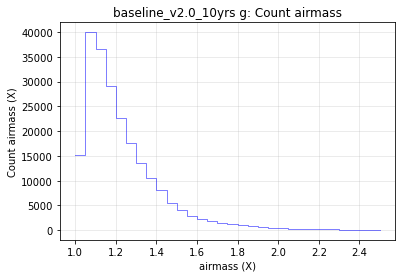

In [17]:
example1_bg.plotAll(closefigs=False)

Be default, `maf.MetricBundleGroup.plotAll` saves plots as pdf files in the current working directory. The save directory can be changed by setting the `outDir` parameter when creating the `MetricBundleGroup`, and the output format by setting `figformat` parameter when calling its `plotAll` method.

### 3.3 Using metric values and slice points directly

We are not limited to creating plots. The *metric bundle* objecs provide access to the metric values and *slice points* themselves, allowing us to use any python tools we like for further analysis or visualization.

These are typically in the form of a `numpy.ma.MaskedArray`:

In [18]:
example1_bundle.metricValues

masked_array(data=[15097.0, 39976.0, 36572.0, 29063.0, 22606.0, 17709.0,
                   13517.0, 10503.0, 8208.0, 5536.0, 4016.0, 2961.0,
                   2308.0, 1841.0, 1475.0, 1181.0, 966.0, 801.0, 694.0,
                   522.0, 462.0, 349.0, 333.0, 294.0, 228.0, 165.0, 136.0,
                   92.0, 64.0, 142.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False],
       fill_value=0.0)

Understanding the values in `MetricBundle.metricValues` often depends on knowning the *slice points* used. In this example, knowing the numbers of visits in each bin is of little help without knowledge of where the bins are. We can get this information by looking directly at the slicer:

In [19]:
example1_bundle.slicer.slicePoints

{'sid': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 'bins': array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
        1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
        2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 ])}

In this case, the `example1_bg.bundleDict['Airmass histogram (g)'].slicer.slicePoints['bins']` gives the bin edges, allowing us to determine which metric values correspond to which bins.

### 3.4 Saved results

In addition to providing access to the plots and metric and slice values through the python interpreter, the *metric bundle group* also saved the plots and values in the `outDir` we provided:

In [20]:
!ls -alth $data_dir

total 1321064
-rw-r--r--   1 neilsen  staff    11K Mar  8 10:20 thumb.baseline_v2_0_10yrs_Count_airmass_g_ONED_BinnedData.png
-rw-r--r--   1 neilsen  staff    13K Mar  8 10:20 baseline_v2_0_10yrs_Count_airmass_g_ONED_BinnedData.pdf
-rw-r--r--   1 neilsen  staff   4.3K Mar  8 10:20 baseline_v2_0_10yrs_Count_airmass_g_ONED.npz
drwxr-xr-x  18 neilsen  staff   576B Mar  8 10:17 .
-rw-r--r--   1 neilsen  staff    11K Mar  8 10:08 thumb.baseline_v2_0_10yrs_Count_HA_g_ONED_BinnedData.png
-rw-r--r--   1 neilsen  staff    12K Mar  8 10:08 baseline_v2_0_10yrs_Count_HA_g_ONED_BinnedData.pdf
-rw-r--r--   1 neilsen  staff   4.7K Mar  8 10:08 baseline_v2_0_10yrs_Count_HA_g_ONED.npz
-rw-r--r--   1 neilsen  staff   9.2K Mar  8 10:08 thumb.baseline_v2_0_10yrs_Count_airmass_r_ONED_BinnedData.png
-rw-r--r--   1 neilsen  staff    12K Mar  8 10:08 baseline_v2_0_10yrs_Count_airmass_r_ONED_BinnedData.pdf
-rw-r--r--   1 neilsen  staff   4.3K Mar  8 10:08 baseline_v2_0_10yrs_Count_airmass_r_ONED.npz
-rw-r--r--

We can see that the plot we just made is present as a `pdf` file. The `npz` file contains the metric and slicer values, from which we can recreate our metric bundle:

In [21]:
from os import path

example1_reloaded = maf.MetricBundle.load(
    path.join(
        data_dir,
        run_name.replace(".", "_") + "_Count_airmass_g_ONED.npz",
    )
)

The metric values are now reloaded:

In [22]:
example1_reloaded.metricValues

masked_array(data=[15097.0, 39976.0, 36572.0, 29063.0, 22606.0, 17709.0,
                   13517.0, 10503.0, 8208.0, 5536.0, 4016.0, 2961.0,
                   2308.0, 1841.0, 1475.0, 1181.0, 966.0, 801.0, 694.0,
                   522.0, 462.0, 349.0, 333.0, 294.0, 228.0, 165.0, 136.0,
                   92.0, 64.0, 142.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False],
       fill_value=0.0)

as is the slicer with its slice points

In [23]:
example1_reloaded.slicer

In [24]:
example1_reloaded.slicer.slicePoints

{'sid': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 'bins': array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
        1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
        2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 ])}

and metric metadata:

In [25]:
example1_reloaded.metadata

'g'

### 3.5 Plot customization

If you want to customize the appearance of the plot, you can set `plotDict` when creating the `MetricBundle`, for example:

Querying table None with constraint filter = 'g' for columns ['airmass']
Found 217817 visits
Running:  ['baseline_v2_0_10yrs_Count_airmass_g_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.


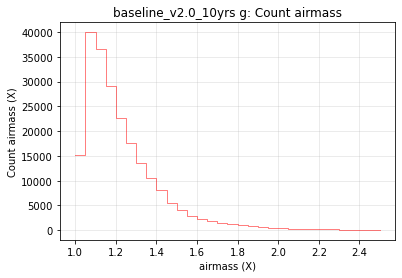

In [26]:
example1a_metric = maf.CountMetric(col="airmass")
example1a_slicer = maf.OneDSlicer(
    sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.05
)
example1a_bundle = maf.MetricBundle(
    example1a_metric,
    example1a_slicer,
    example1_constraint,
    runName=run_name,
    plotDict={"color": "r"},
)
example1a_bg = maf.MetricBundleGroup([example1a_bundle], dbCon=example1_opsim_db)
example1a_bg.runAll()
example1a_bg.plotAll(closefigs=False)

## 4. Comparing two simulations

To compare two simulations, we need a second one to compare our first one with.

If you already have one, set it here:

In [27]:
from os import path

other_opsim_fname = path.join(data_dir, "rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db")

If we are at NOIR's datalab, we might be able to find it in a standard location, so look there:

In [28]:
if not path.exists(other_opsim_fname):
    datalab_opsim_fname = (
        "/sims_maf/fbs_2.0/rolling_all_sky/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db"
    )
    if os.path.exists(datalab_opsim_fname):
        other_opsim_fname = datalab_opsim_fname

If it isn't already there, try to download it:

In [29]:
if not path.exists(other_opsim_fname):
    import urllib

    other_opsim_fname, _ = urllib.request.urlretrieve(
        "https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs2.0/rolling_all_sky/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db",
        other_opsim_fname,
    )

other_opsim_fname

'/Users/neilsen/data/maf/rolling_all_sky_ns2_rw0.9_v2.0_10yrs.db'

and assign it a run name, just as we did with our baseline simulation above:

In [30]:
from os.path import splitext, basename

other_run_name = splitext(basename(other_opsim_fname))[0]
other_run_name

'rolling_all_sky_ns2_rw0.9_v2.0_10yrs'

Repeat the process show in example 1 to calculate metrics for the other example database:

In [31]:
example2_opsim_db = maf.OpsimDatabase(other_opsim_fname)
example2_constraint = "filter = 'g'"
example2_slicer = maf.OneDSlicer(
    sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.05
)
example2_metric = maf.CountMetric(col="airmass")
example2_bundle = maf.MetricBundle(
    example2_metric,
    example2_slicer,
    example2_constraint,
    runName=other_run_name,
)
example2_bg = maf.MetricBundleGroup(
    [example2_bundle], dbCon=example2_opsim_db, outDir=data_dir
)
example2_bg.runAll()

Querying table None with constraint filter = 'g' for columns ['airmass']
Found 218059 visits
Running:  ['rolling_all_sky_ns2_rw0_9_v2_0_10yrs_Count_airmass_g_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


We can use a *plot handler* to combine plots of the first and second databases:

1

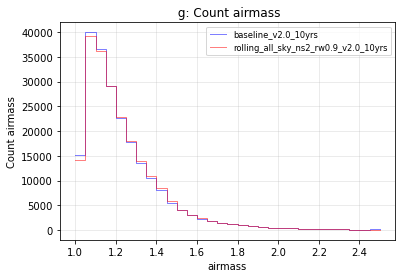

In [32]:
example2_ph = maf.PlotHandler()

example2_ph.setMetricBundles([example1_bundle, example2_bundle])
plotDicts = [
    {"label": run_name, "color": "b"},
    {"label": other_run_name, "color": "r"},
]

example2_ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotDicts)

## 5. A metric that maps the sky: depth in *r*

Making maps follows a similar procedure, but uses a slicer that slices based on position in the sky, usually `rubin_sim.maf.slicers.HealpixSlicer`.
`HealpixSlicer` creates a slice for each [healpixel](https://arxiv.org/abs/astro-ph/9905275), and each slice contains all visits that over that slice's healpixel.

First, lets sets the constraint only to look at visits in *r*:

In [33]:
example3_constraint = "filter = 'r'"

To make a map, we need to slice the visits by pointing on the sky. Note that the same visit may appear in multiple slices, so this will work correctly even in the resolution of the map is smaller than the camera footprint.

In [34]:
example3_slicer = maf.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


We want to map the coadd depth, so we select a metric that estimates the coadd depth from all visits in a slice:

In [35]:
example3_metric = maf.Coaddm5Metric()

Now, we group these together in a metric bundle, create a metric bundle group, and calculate the metrics just as we did in example 1. Note that we are reusing the same database we used in example 1.

In [36]:
example3_bundle = maf.MetricBundle(
    example3_metric,
    example3_slicer,
    example3_constraint,
    runName=run_name,
)
example3_bg = maf.MetricBundleGroup(
    [example3_bundle], dbCon=example1_opsim_db, outDir=data_dir
)
example3_bg.runAll()

Querying table None with constraint filter = 'r' for columns ['rotSkyPos', 'fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 464851 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


0.0 180.0 -180.0 180.0


Plotting figures with "filter = 'r'" constraint now.
Plotting complete.


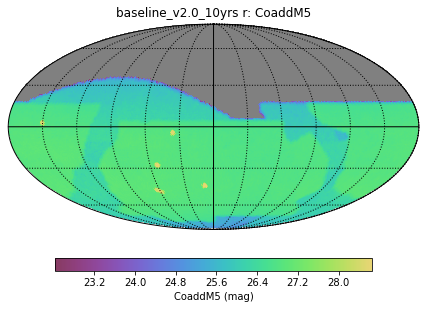

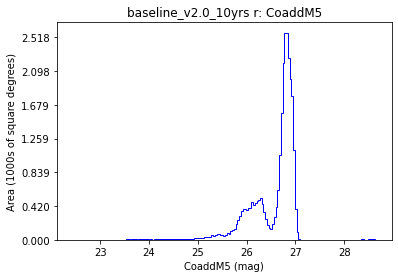

In [37]:
example3_bg.plotAll(closefigs=False)

Again, the values of the metric and slice point can be used directly:

In [38]:
example3_bundle.metricValues

masked_array(data=[--, --, --, ..., 25.014038787537217,
                   25.094162184230395, 25.071797858152166],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=-1.6375e+30)

The *slice points* themselves are expressed using a different structure, reflecting the different way in which the visits were sliced:

In [39]:
example3_bundle.slicer.slicePoints

{'sid': array([    0,     1,     2, ..., 49149, 49150, 49151]),
 'ra': array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
        5.49778714]),
 'dec': array([ 1.55803848,  1.55803848,  1.55803848, ..., -1.55803848,
        -1.55803848, -1.55803848]),
 'nside': 64,
 'gall': array([2.15315112, 2.15774712, 2.13789791, ..., 5.2750634 , 5.29474377,
        5.29933977]),
 'galb': array([ 0.462663  ,  0.48023432,  0.48426801, ..., -0.4666605 ,
        -0.462663  , -0.48023432])}

Note that, for the `maf.HealpixSlicer`, the `sid` is the `healpix` index (`ipix` in the [healpy documentation](https://healpy.readthedocs.io/en/latest/)), and `ra` and `dec` are in radians, not degrees.

## 6. Plot customization after initial plotting

Plots may be customized after the initial execution through the bundle group, without recomputation of the metric. This is done by using the `plot` method of the metric bundle itself.

For example, you can adjust the parameters of the Mollweide projection to put the south pole at the center, such that the footprint is in the low distortion area at the center of the projection, and the area near the north pole at the high distortion area on the far left and right:

0.0 180.0 -180.0 180.0


{'SkyMap': 1}

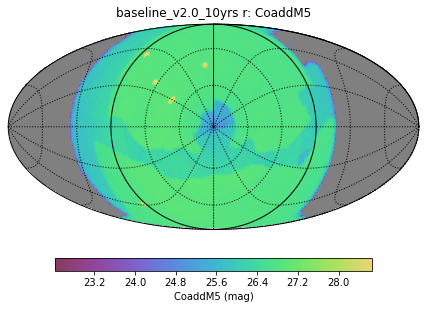

In [40]:
example3_bundle.setPlotDict({"rot": (0, -90, 0)})
example3_bundle.setPlotFuncs([maf.HealpixSkyMap()])
example3_bundle.plot()

## 7. Summary statistics

In addition to creating figures, MAF can calculate "summary statistics," sets of values that summarize metrics.

For example, to get statistics on the coadd depth over the sky, we can add summary metrics to example 3.

First, make a list of the metrics, define a new metric bundle that includes them, and create a bundle group to actually calculate the values of the metrics:

In [41]:
example3a_slicer = maf.HealpixSlicer(nside=64)
example3a_metric = maf.Coaddm5Metric()
example3a_summary_metrics = [
    maf.MinMetric(),
    maf.MedianMetric(),
    maf.MaxMetric(),
    maf.RmsMetric(),
]
example3a_bundle = maf.MetricBundle(
    example3a_metric,
    example3a_slicer,
    example3_constraint,
    summaryMetrics=example3a_summary_metrics,
    runName=run_name,
)
example3a_bg = maf.MetricBundleGroup(
    [example3a_bundle], dbCon=example1_opsim_db, outDir=data_dir
)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Then, use the bundle group to drive the calculation of the metrics and summary metrics:

In [42]:
example3a_bg.runAll()
example3a_bg.summaryAll()

Querying table None with constraint filter = 'r' for columns ['rotSkyPos', 'fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 464851 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Finally, look a the summary values:

In [43]:
example3a_bundle.summaryValues

{'Min': 22.424726156674502,
 'Median': 26.75597110040065,
 'Max': 28.663863584873113,
 'Rms': 0.48101183219246374}

## 8. Working with multiple metrics on the same simulation at once

As implied by the name "metric bundle group", multiple metric bundles can be combined into the some group and calculated "in one go".

Start by creating two new *metric bundles*:

In [44]:
example4_bundles = {
    "g": maf.MetricBundle(
        metric=maf.CountMetric(col="airmass"),
        slicer=maf.OneDSlicer(
            sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.05
        ),
        constraint="filter = 'g'",
        plotDict={"color": "g"},
        runName=run_name,
    ),
    "r": maf.MetricBundle(
        metric=maf.CountMetric(col="airmass"),
        slicer=maf.OneDSlicer(
            sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.05
        ),
        constraint="filter = 'r'",
        plotDict={"color": "r"},
        runName=run_name,
    ),
}

Now add them both to the same *bundle group*:

Querying table None with constraint filter = 'r' for columns ['airmass']
Found 464851 visits
Running:  ['r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = 'g' for columns ['airmass']
Found 217817 visits
Running:  ['g']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = 'r'" constraint now.
Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.


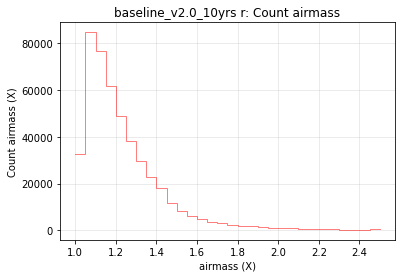

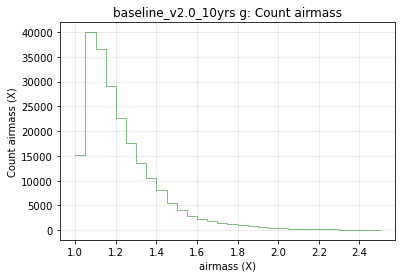

In [45]:
example4_bg = maf.MetricBundleGroup(
    example4_bundles, dbCon=example1_opsim_db, outDir=data_dir
)
example4_bg.runAll()
example4_bg.plotAll(closefigs=False)

## 9. Finding available database columns with which to express constraints, slices, and metrics

The contents of the opsim databases can vary slightly with the version of the opsim, but they are mostly similar. To list the columns in the database 

In [46]:
import sqlite3

with sqlite3.connect(example1_opsim_db) as connection:
    cursor = connection.cursor()
    cursor.execute("SELECT name FROM PRAGMA_TABLE_INFO('observations')")
    columns = [r[0] for r in cursor]

print(", ".join(columns))

observationId, fieldRA, fieldDec, observationStartMJD, flush_by_mjd, visitExposureTime, filter, rotSkyPos, numExposures, airmass, seeingFwhm500, seeingFwhmEff, seeingFwhmGeom, skyBrightness, night, slewTime, visitTime, slewDistance, fiveSigmaDepth, altitude, azimuth, paraAngle, cloud, moonAlt, sunAlt, note, fieldId, proposalId, block_id, observationStartLST, rotTelPos, moonAz, sunAz, sunRA, sunDec, moonRA, moonDec, moonDistance, solarElong, moonPhase, cummTelAz


In addition to the columns present in the database, a number of quantities derived from them can be automatically calculated "on the fly" and used as if they were database columns. MAF calculates thes derived parameters using *stackers*. 

For example, hour angle is not a column in the database, but MAF includes the `rubin_sim.maf.HourAngleStacker`, and so `HA` can be used as if it were a column:

Querying table None with constraint filter = 'g' for columns ['observationStartLST', 'fieldRA']
Found 217817 visits
Running:  ['baseline_v2_0_10yrs_Count_HA_g_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.


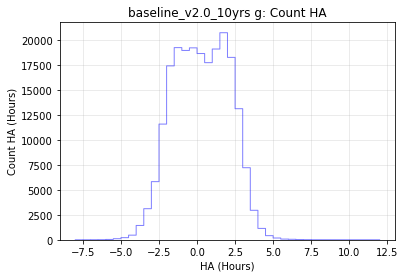

In [47]:
example5_constraint = "filter = 'g'"
example5_slicer = maf.OneDSlicer(
    sliceColName="HA", binMin=-12.0, binMax=12, binsize=0.5
)
example5_metric = maf.CountMetric(col="HA")
example5_bundle = maf.MetricBundle(
    example5_metric,
    example5_slicer,
    example1_constraint,
    runName=run_name,
)
example5_bg = maf.MetricBundleGroup(
    [example5_bundle], dbCon=example1_opsim_db, outDir=data_dir
)
example5_bg.runAll()
example5_bg.plotAll(closefigs=False)

You can list available *stackers* and the columns they create thus:

In [48]:
import pprint

pprint.pprint({k: v.colsAdded for k, v in maf.BaseStacker.registry.items()})

{'AppMagNullStacker': ['appMag'],
 'AppMagStacker': ['appMag'],
 'BaseDitherStacker': [],
 'BaseMoStacker': [],
 'CoaddStacker': ['coadd'],
 'CometAppMagStacker': ['appMag'],
 'DcrStacker': ['ra_dcr_amp', 'dec_dcr_amp'],
 'EclStacker': ['ecLat', 'ecLon'],
 'EclipticStacker': ['eclipLat', 'eclipLon'],
 'FiveSigmaStacker': ['m5_simsUtils'],
 'GalacticStacker': ['gall', 'galb'],
 'HexDitherFieldPerNightStacker': ['hexDitherFieldPerNightRa',
                                   'hexDitherFieldPerNightDec'],
 'HexDitherFieldPerVisitStacker': ['hexDitherFieldPerVisitRa',
                                   'hexDitherFieldPerVisitDec'],
 'HexDitherPerNightStacker': ['hexDitherPerNightRa', 'hexDitherPerNightDec'],
 'HourAngleStacker': ['HA'],
 'M5OptimalStacker': ['m5Optimal'],
 'MoMagStacker': ['appMag', 'SNR', 'vis'],
 'NEODistStacker': ['MaxGeoDist', 'NEOHelioX', 'NEOHelioY'],
 'NFollowStacker': ['nObservatories'],
 'NormAirmassStacker': ['normairmass'],
 'ParallacticAngleStacker': ['PA'],
 'P

## 10. Finding available *metrics* and *slicers*

MAF includes a variety of *metrics* and *slicers*, and python's "help" can indicate what each is for and how to use them.

You can discover the metrics that are there using the slicer and metric registries:

In [49]:
tuple(maf.BaseSlicer.registry)

('UniSlicer',
 'OneDSlicer',
 'NDSlicer',
 'MovieSlicer',
 'HourglassSlicer',
 'HealpixSlicer',
 'HealpixSubsetSlicer',
 'HealpixSDSSSlicer',
 'UserPointsSlicer',
 'MoObjSlicer',
 'HealpixComCamSlicer',
 'TimeIntervalSlicer',
 'BlockIntervalSlicer',
 'VisitIntervalSlicer')

A similar simple list of metrics can be obtained using the same technique, and evaluating `tuple(maf.BaseMetric.registry)`.

`maf.BaseMetric.help()` will also show the simple list of metrics, and supports a `doc=True` option that prints more documentation on each metric:


In [50]:
maf.BaseMetric.help(doc=True)

----  AGN_TimeLagMetric  ----
Base class for the metrics.
Sets up some basic functionality for the MAF framework: after __init__ every metric will
record the columns (and stackers) it requires into the column registry, and the metricName,
metricDtype, and units for the metric will be set.

Parameters
----------
col : `str` or `list` [`str`]
    Names of the data columns that the metric will use.
    The columns required for each metric is tracked in the ColRegistry, and used to retrieve data
    from the opsim database. Can be a single string or a list.
metricName : `str`
    Name to use for the metric (optional - if not set, will be derived).
maps : `list` [`rubin_sim.maf.maps`]
    The maps that the metric will need (passed from the slicer).
units : `str`
    The units for the value returned by the metric (optional - if not set,
    will be derived from the ColInfo).
metricDtype : `str`
    The type of value returned by the metric - 'int', 'float', 'object'.
    If not set, will be d